# Homework 2

In this homework, we are gonna perform some EDA work on our browser history!

Extract & prepare your history dataset using: 
https://github.com/msaricaumbc/DS601/blob/main/Week09/homework/preparation_BrowserHistory.ipynb

DO NOT commit your history dataset!

Watch this: https://www.youtube.com/watch?v=iFTWM7HV2UI

Investigate the data and try to answer the following question.

1. Is this a work computer/personal computer?
1. Is user employed?
1. What are the person's interests?
1. Anything interesting?

What else can we tell about this person?

In [62]:
import sqlite3
from datetime import datetime, timedelta
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
temp_db = "Brave_History_Copy.db"

In [64]:
'''
I use brave browser. So, I had to do some changes to retrieve the domain names and the timestamp.
Looks like the original libarary only supports chrome browser.

'''
conn = sqlite3.connect(temp_db)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the Brave History database:")
for table in tables:
    print(table[0])

Tables in the Brave History database:
meta
downloads
downloads_url_chains
downloads_slices
history_sync_metadata
urls
sqlite_sequence
visits
visit_source
visited_links
keyword_search_terms
segments
segment_usage
content_annotations
context_annotations
clusters
clusters_and_visits
cluster_keywords
cluster_visit_duplicates


In [ ]:
# Connect to the copied database
conn = sqlite3.connect(temp_db)
cursor = conn.cursor()

# Query to join urls and visits table
cursor.execute("""
    SELECT urls.url, visits.visit_time
    FROM urls
    JOIN visits ON urls.id = visits.url
    ORDER BY visits.visit_time DESC
""")

# Fetch results
history = cursor.fetchall()

In [66]:
history

[('https://chatgpt.com/c/67a59025-d0e0-8006-9606-77772c1c1c90',
  13383377188501338),
 ('https://chatgpt.com/', 13383377178982731),
 ('https://chat.com/', 13383377178982731),
 ('https://stackoverflow.com/questions/64321899/the-module-browserhistory-doesnt-seem-to-work-and-raises-keyerror',
  13383377158195728),
 ('https://www.google.com/search?q=bh.get_browserhistory&oq=bh.get_browserhistory&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIGCAEQLhhA0gEHMTAxajBqMagCALACAA&sourceid=chrome&ie=UTF-8',
  13383377155637564),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc&ab_channel=L%E1%B4%8F%C9%B4%E1%B4%87%D2%93%C9%AA%C9%B4%C9%AA%E1%B4%9B%CA%8F',
  13383377138040530),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc', 13383377138034982),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc&ab_channel=L%E1%B4%8F%C9%B4%E1%B4%87%D2%93%C9%AA%C9%B4%C9%AA%E1%B4%9B%CA%8F',
  13383377137380855),
 ('https://www.youtube.com/watch?v=AcaneopJ5rc', 13383377137186601),
 ('http://localhost:8888/notebooks/hw2-eda-metadata-analysis_

In [16]:
urls=[]
times = []

# this will just convert the webkit timestamp to the standard UTC timestamp
def convert_time(webkit_timestamp):
    epoch_start = datetime(1601, 1, 1)
    return epoch_start + timedelta(microseconds=webkit_timestamp)


# parse the url to get domain
def get_domain(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc  
    return domain.replace("www.", "") 

# get datetimestamp and domain names and appending them to the corresponding lists
# to create our pandas dataframe
for url, timestamp in history:
    times.append(convert_time(timestamp))
    urls.append(get_domain(url))

df = pd.DataFrame({"date": times, "domain": urls})

In [17]:
df

,date,domain
0,2025-02-07 04:46:28.501338,chatgpt.com
1,2025-02-07 04:46:18.982731,chatgpt.com
2,2025-02-07 04:46:18.982731,chat.com
3,2025-02-07 04:45:58.195728,stackoverflow.com
4,2025-02-07 04:45:55.637564,google.com
...,...,...
77201,2024-12-07 02:34:48.221062,accounts.google.com
77202,2024-12-07 02:34:48.221062,mail.google.com
77203,2024-12-07 02:34:48.221062,gmail.com
77204,2024-12-07 02:34:45.561978,google.com


In [18]:
df["date"].min(), df["date"].max()

(Timestamp('2024-12-07 02:34:44.975372'),
 Timestamp('2025-02-07 04:46:28.501338'))

Looks like I had cleared my browsing history in the early december last year. Still, that should be fine as I have more than 77k records.

In [19]:
df.shape

(77206, 2)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77206 entries, 0 to 77205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    77206 non-null  datetime64[ns]
 1   domain  77206 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.2+ MB


Both columns have not-null values. That's good. Let's extract Year, Month, Day, Hour, and weekday columns from the dataframe

In [22]:
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month
df["Day"] = df["date"].dt.day
df["Hour"] = df["date"].dt.hour
df["Day"] = df["date"].dt.day_name() # gets day name using pandas' built-in calender

In [28]:
# remove ".com" from domain names
df["domain"] = df["domain"].apply(lambda x : x.split(".")[0])

In [103]:
df["domain"].fillna("Unknown", inplace=True)

In [104]:
df.head()

,date,domain,Year,Month,Day,Hour
0,2025-02-07 04:46:28.501338,chatgpt,2025,2,Friday,4
1,2025-02-07 04:46:18.982731,chatgpt,2025,2,Friday,4
2,2025-02-07 04:46:18.982731,chat,2025,2,Friday,4
3,2025-02-07 04:45:58.195728,stackoverflow,2025,2,Friday,4
4,2025-02-07 04:45:55.637564,google,2025,2,Friday,4


# Top 20 Most Visited Pages

In [105]:
most_visited_sites_based_on_count = df.groupby("domain")["date"].count().reset_index()
most_visited_sites_based_on_count.rename(columns={"date": "count"}, inplace=True)
most_visited_sites_based_on_count.sort_values("count", inplace=True, ascending=False)
most_visited_sites_based_on_count_top20 = most_visited_sites_based_on_count[: 20] # top 20

In [106]:
most_visited_sites_based_on_count_top20

,domain,count
751,youtube,14316
747,x,8545
306,google,6498
423,mail,5785
365,instagram,5659
566,robinhood,4738
264,facebook,2656
410,linkedin,2587
723,walmart,2004
38,amazon,1978


Text(0.5, 1.0, 'Visualizing the number of times the top 10 sites were visited')

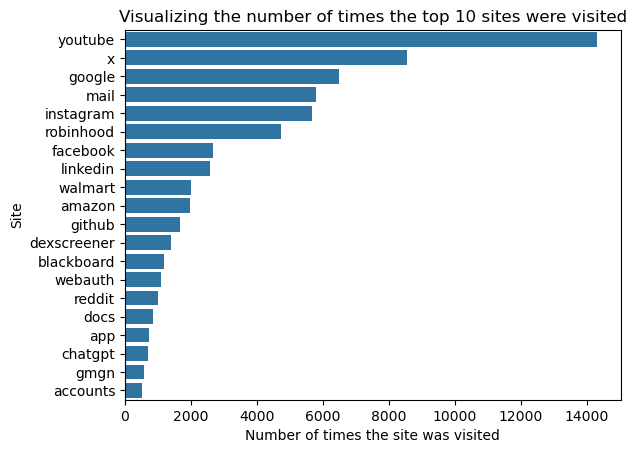

In [107]:
sns.barplot(x = most_visited_sites_based_on_count_top20["count"], y = most_visited_sites_based_on_count_top20["domain"])
plt.xlabel("Number of times the site was visited")
plt.ylabel("Site")
plt.title("Visualizing the number of times the top 10 sites were visited")

Well, I love youtube and Twitter (X). I also am very active in trading. So, thats probably why robinhood, dexscreener and gmgn are amongst the top 15 most visited sites.

In [108]:
df["Month"].value_counts()

Month
1     38514
12    28699
2      9993
Name: count, dtype: int64

Since I had cleared my browsing history just 2 months ago, visualizing based on months is probably not going to be useful as I only have 3 months worth of data.

In [109]:
df["Hour"].value_counts()

Hour
18    8479
19    8053
2     6968
17    6728
20    6585
3     5948
1     5515
0     5098
21    4834
22    4087
4     4028
23    3959
16    3860
15    1362
5      830
6      430
14     291
7      109
13      42
Name: count, dtype: int64

Let's look at hourly variations

In [110]:
number_of_visits_based_on_hour = df.groupby("Hour")["date"].count().reset_index()
number_of_visits_based_on_hour.rename(columns = {"date": "count"}, inplace=True)
number_of_visits_based_on_hour

,Hour,count
0,0,5098
1,1,5515
2,2,6968
3,3,5948
4,4,4028
5,5,830
6,6,430
7,7,109
8,13,42
9,14,291


Text(0.5, 1.0, 'Number of visits based on hour')

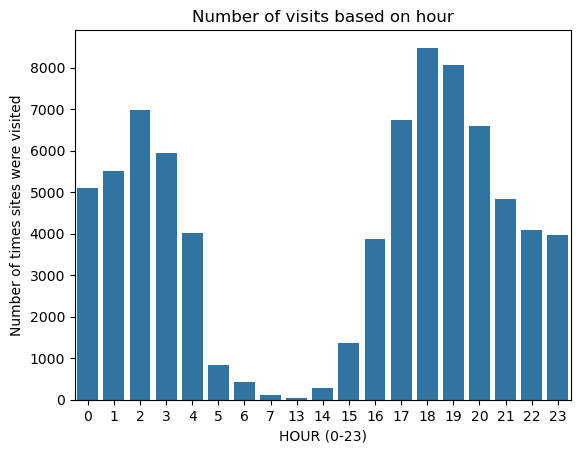

In [111]:
sns.barplot(x="Hour", y = "count", data=number_of_visits_based_on_hour)
plt.xlabel("HOUR (0-23)")
plt.ylabel("Number of times sites were visited")
plt.title("Number of visits based on hour")

I am pretty active in the late and early morning watching youtube and trading. That could be the reason there are larger bars in the early morning and late evening. However, the afternoons have very low visits. Most of my work related meetings happen in that time. That could be the reason as I won't be watching stuff then.

<b> Let's see the same thing but during weekdays and weekends

In [112]:
weekend_df = df[df.Day.isin(["Saturday", "Sunday"])]
weekday_df = df[~df.Day.isin(["Saturday", "Sunday"])]

In [113]:
weekend_df.Day.unique().shape, weekday_df.Day.unique().shape

((2,), (5,))

In [114]:
weekend_df = weekend_df.groupby("Hour")["date"].count().reset_index()
weekend_df.rename(columns = {"date": "count"}, inplace=True)

weekday_df = weekday_df.groupby("Hour")["date"].count().reset_index()
weekday_df.rename(columns = {"date": "count"}, inplace=True)

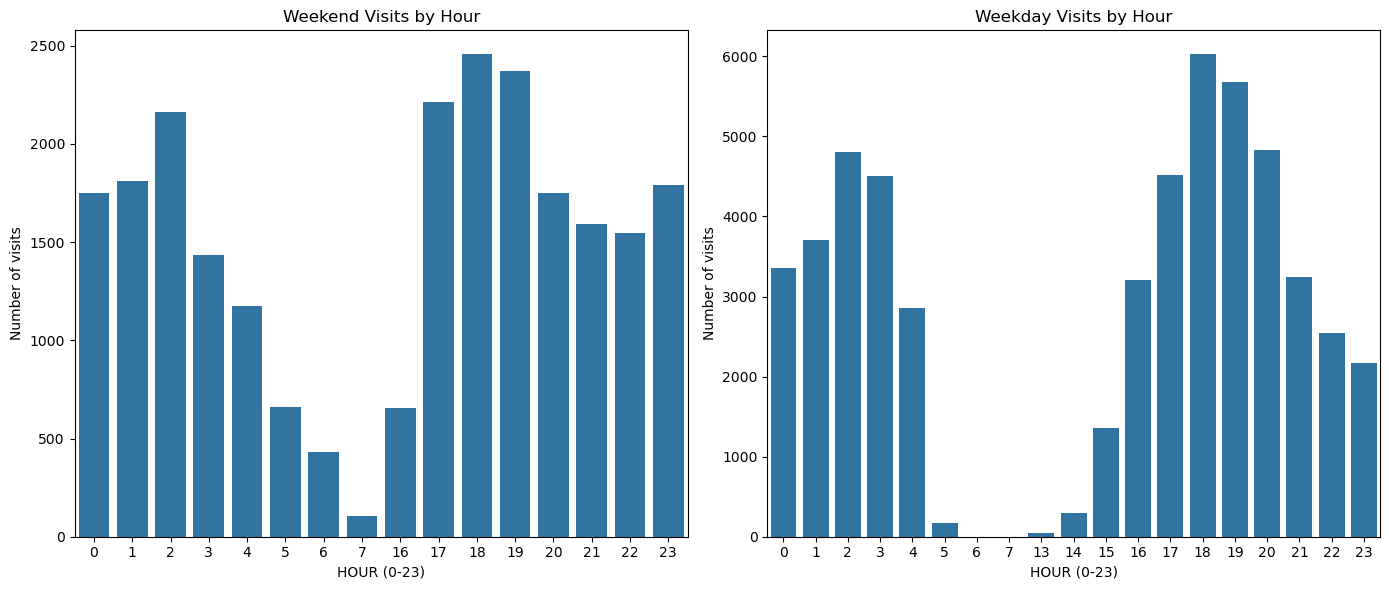

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for weekends
sns.barplot(x="Hour", y="count", data=weekend_df, ax=axes[0])
axes[0].set_xlabel("HOUR (0-23)")
axes[0].set_ylabel("Number of visits")
axes[0].set_title("Weekend Visits by Hour")

# Plot for weekdays
sns.barplot(x="Hour", y="count", data=weekday_df, ax=axes[1])
axes[1].set_xlabel("HOUR (0-23)")
axes[1].set_ylabel("Number of visits")
axes[1].set_title("Weekday Visits by Hour")

plt.tight_layout()
plt.show()


We can see that the pattern on both weekdays and weekends is very similar. My work is fully remote and very flexible. So, my schedule and timing being in front of the laptop screen is pretty consistent across all days. 

In [116]:
visits_by_days = df.groupby("Day")["date"].count().reset_index()
visits_by_days = visits_by_days.rename(columns={"date": "count"})

In [117]:
visits_by_days

,Day,count
0,Friday,9866
1,Monday,12290
2,Saturday,12451
3,Sunday,11456
4,Thursday,11519
5,Tuesday,10398
6,Wednesday,9226


<b> Lets sort the dataframe based on days

In [118]:
# this is the order selected
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# convert the Day column into categorical form and ordering the categories based on the above order, and sorting them
visits_by_days["Day"] = pd.Categorical(visits_by_days["Day"], categories=order, ordered=True)
visits_by_days = visits_by_days.sort_values("Day").reset_index(drop=True)

In [119]:
visits_by_days

,Day,count
0,Monday,12290
1,Tuesday,10398
2,Wednesday,9226
3,Thursday,11519
4,Friday,9866
5,Saturday,12451
6,Sunday,11456


Text(0.5, 1.0, 'Number of visits accross the week')

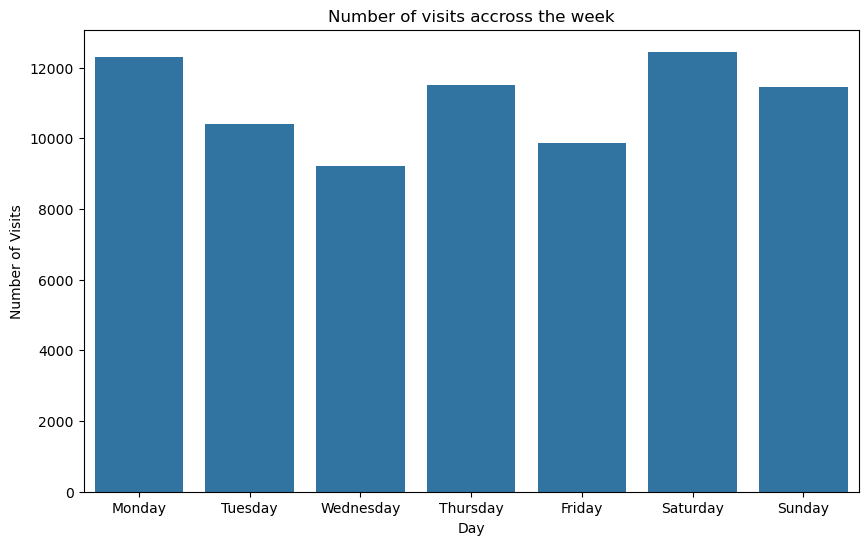

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(x=visits_by_days["Day"], y = visits_by_days["count"], ax=ax)
plt.xlabel("Day")
plt.ylabel("Number of Visits")
plt.title("Number of visits accross the week")

There is no definitive pattern to look for here as it is the same pattern as hourly basis. Since all of my work is remote and flexible, this plot does not show any sort of distinction like you would see for someone's browsing history who does 9-5 in person job.